# RNA Modification Detection - Dorado High m6Anet Low
## Analysis of m6A modifications using ML scores from DRS nanopore sequencing

## Imports

In [1]:
import pickle
import numpy as np
import pandas as pd
import sys
from numba import njit, prange
import seaborn as sns
from tqdm import tqdm
from genometechlab_plotting import setup_style
from matplotlib import gridspec
import matplotlib.pyplot as plt
setup_style('inline')
from sklearn.metrics import confusion_matrix, classification_report
import warnings
warnings.filterwarnings('ignore')

Loaded 7 Helvetica fonts


## Define Global Parameters and Modification Mapping

In [2]:
"""
This notebook analyzes the Dorado_High_m6Anet_Low oligonucleotide pair.

The analysis compares ML scores between Modified and unModified samples to:
1. Visualize score distributions at each position
2. Calculate classification metrics (confusion matrix)
3. Assess modification detection performance
"""

# Modification type mapping (for multi-modification experiments)
MODIFICATION_MAPPING = {
    "m6A": 0, "Inosine": 1, "2'OmeA": 2,
    "2'OMeG": 3,
    "m5C": 4, "2'OMeC": 5,
    "Psi": 6, "2'OMeU": 7
}

# Threshold for modification calling (70% of max score)
MODIFICATION_THRESHOLD = 0.70 * 255  # 178.5

# Positions where modifications are expected in psU_PhMl oligonucleotide
EXPECTED_Modified_POSITIONS = [56, 59, 60, 63, 64]
OLIGO = "Dorado_High_m6Anet_Low"

print(f"Analyzing modification type: m6A")
print(f"Modification threshold: {MODIFICATION_THRESHOLD:.1f}")
print(f"Expected Modified positions: {EXPECTED_Modified_POSITIONS}")

Analyzing modification type: m6A
Modification threshold: 178.5
Expected Modified positions: [56, 59, 60, 63, 64]


## Data Preparation Functions

In [3]:
def load_pickle_file(file_path, debug=False):
    """
    Load a pickle file containing read data or mappings.
    
    Args:
        file_path: Path to the pickle file
        debug: If True, print debug information
    
    Returns:
        Loaded object from pickle file
    """
    try:
        with open(file_path, "rb") as f:
            obj = pickle.load(f)
        if debug:
            print(f"[DEBUG] Successfully loaded pickle file: {file_path}")
        return obj
    except FileNotFoundError:
        print(f"[ERROR] File '{file_path}' not found.")
        return None
    except Exception as e:
        print(f"[ERROR] An error occurred while loading '{file_path}': {e}")
        return None

def prepare_data(read_arrays_dict, read_to_ref_dict, allowed_ref_names=None, debug=False):
    """
    Prepare and structure the data for analysis.
    
    Args:
        read_arrays_dict: Dictionary of read_id -> array mappings
        read_to_ref_dict: Dictionary of read_id -> reference mappings
        allowed_ref_names: List of reference names to include
        debug: Enable debug output
    
    Returns:
        Tuple of prepared arrays and mappings
    """
    # Get reference names
    ref_names = sorted(set(read_to_ref_dict.values()).intersection(allowed_ref_names)) \
                if allowed_ref_names else sorted(set(read_to_ref_dict.values()))
    ref_name_to_idx = {name: idx for idx, name in enumerate(ref_names)}
    
    # Calculate position adjustments for IVT samples
    subtract_amount = np.array([3 if name.endswith("_IVT") else 0 for name in ref_names], dtype=np.int16)
    
    all_read_arrays = []
    all_read_to_ref_idx = []
    
    # Determine array structure
    if read_arrays_dict:
        sample_array = next(iter(read_arrays_dict.values()))
        num_cols = sample_array.shape[1] if sample_array.ndim > 1 else len(sample_array)
        if debug:
            print(f"[DEBUG] Array structure: {num_cols} columns")
    
    # Process each read
    for read_id, ref_name in read_to_ref_dict.items():
        if allowed_ref_names and ref_name not in allowed_ref_names:
            continue
        
        arr = read_arrays_dict.get(read_id)
        if arr is not None:
            if arr.ndim == 1:
                arr = arr.reshape(1, -1)
            
            all_read_arrays.append(arr)
            ref_idx = ref_name_to_idx[ref_name]
            all_read_to_ref_idx.extend([ref_idx] * arr.shape[0])
    
    # Convert to numpy arrays
    all_read_arrays = np.vstack(all_read_arrays) if all_read_arrays else np.empty((0, 1), dtype=np.float64)
    all_read_to_ref_idx = np.array(all_read_to_ref_idx, dtype=np.int32)
    num_ml_scores = all_read_arrays.shape[1] - 3  # Columns minus [read_pos, ref_pos, base_quality]
    
    if debug:
        print(f"[DEBUG] Prepared {len(all_read_arrays)} read arrays")
        print(f"[DEBUG] Number of ML score columns: {num_ml_scores}")
    
    return all_read_arrays, all_read_to_ref_idx, subtract_amount, num_ml_scores, ref_names, ref_name_to_idx

print("Data preparation functions loaded successfully!")

Data preparation functions loaded successfully!


## Data Gathering

In [4]:
@njit(parallel=False)
def gather_data(all_read_to_ref_idx, all_read_arrays, subtract_amount, num_ml_scores, target_ml_tag_idx=None):
    """
    Numba-accelerated function to gather and process read data.
    
    Args:
        all_read_to_ref_idx: Array of reference indices for each read
        all_read_arrays: Stacked array of all read data
        subtract_amount: Position adjustment for each reference
        num_ml_scores: Number of ML score columns
        target_ml_tag_idx: Which ML score column to use (if multiple)
    
    Returns:
        Tuple of (ref_idx, ref_pos, ml_score, condition) arrays
    """
    num_rows = all_read_arrays.shape[0]
    
    # Pre-allocate output arrays
    ref_idx_list = np.empty(num_rows, dtype=np.uint8)
    ref_pos_list = np.empty(num_rows, dtype=np.int16)
    ml_score_list = np.empty(num_rows, dtype=np.uint8)
    condition_list = np.empty(num_rows, dtype=np.uint8)
    
    # Determine which ML score column to use
    if num_ml_scores == 1 or target_ml_tag_idx is None:
        ml_idx = all_read_arrays.shape[1] - 1  # Last column
    else:
        ml_idx = 3 + target_ml_tag_idx  # Skip first 3 columns
    
    count = 0
    for i in prange(num_rows):
        ref_idx = all_read_to_ref_idx[i]
        if ref_idx == -1:
            continue
        
        subtract = subtract_amount[ref_idx]
        ref_pos = int(all_read_arrays[i, 1] - subtract)
        
        if ml_idx < all_read_arrays.shape[1]:
            score = all_read_arrays[i, ml_idx]
        else:
            continue
        
        if score != -1:
            ref_idx_list[count] = ref_idx
            ref_pos_list[count] = ref_pos
            ml_score_list[count] = score
            condition_list[count] = 1 if subtract == 3 else 0  # 1 for IVT, 0 for Modified
            count += 1
    
    return (
        ref_idx_list[:count],
        ref_pos_list[:count],
        ml_score_list[:count],
        condition_list[:count]
    )

print("Numba-accelerated functions compiled successfully!")

Numba-accelerated functions compiled successfully!


## Data Filtering and Conversion

In [5]:
def filter_gathered_data(ref_idx, ref_pos, ml_score, condition, positions_dict, ref_name_to_idx, debug=False):
    """
    Filter data to only include specified positions for each reference.
    
    Args:
        ref_idx: Reference index array
        ref_pos: Reference position array
        ml_score: ML score array
        condition: Condition array (IVT vs Modified)
        positions_dict: Dictionary of reference -> allowed positions
        ref_name_to_idx: Mapping of reference names to indices
        debug: Enable debug output
    
    Returns:
        Filtered arrays
    """
    valid_indices = []
    
    for ref_name, allowed_positions in positions_dict.items():
        if ref_name in ref_name_to_idx:
            idx = ref_name_to_idx[ref_name]
            mask = (ref_idx == idx) & np.isin(ref_pos, allowed_positions)
            
            if debug:
                print(f"[DEBUG] Filtering {ref_name}: {np.sum(mask)} valid positions")
            
            valid_indices.append(np.where(mask)[0])
    
    if valid_indices:
        valid_indices = np.concatenate(valid_indices)
    else:
        valid_indices = np.array([], dtype=int)
    
    return (
        ref_idx[valid_indices],
        ref_pos[valid_indices],
        ml_score[valid_indices],
        condition[valid_indices]
    )

def convert_to_dataframe(ref_idx, ref_pos, ml_score, condition, ref_names_sorted):
    """
    Convert arrays to a pandas DataFrame for analysis.
    
    Args:
        ref_idx: Reference index array
        ref_pos: Reference position array
        ml_score: ML score array
        condition: Condition array
        ref_names_sorted: Sorted list of reference names
    
    Returns:
        DataFrame with structured data
    """
    df = pd.DataFrame({
        'ref_idx': ref_idx,
        'ref_pos': ref_pos,
        'ML_score': ml_score,
        'condition': np.where(condition == 1, "IVT", "Modified")
    })
    df['ref_name'] = df['ref_idx'].apply(lambda x: ref_names_sorted[x])
    return df[['ref_idx', 'ref_name', 'ref_pos', 'ML_score', 'condition']]

print("Data filtering and conversion functions loaded!")


Data filtering and conversion functions loaded!


## Main Data Processing Pipeline

In [6]:
def process_data(read_arrays_dict, read_to_ref_dict, mod="m6A", positions_dict=None, debug=False):
    """
    Main processing pipeline for RNA modification data.
    
    Args:
        read_arrays_dict: Dictionary of read arrays
        read_to_ref_dict: Dictionary mapping reads to references
        mod: Modification type to analyze
        positions_dict: Dictionary of positions to analyze
        debug: Enable debug output
    
    Returns:
        Processed DataFrame
    """
    # Get target ML tag index for the modification
    target_ml_tag_idx = MODIFICATION_MAPPING.get(mod)
    
    # Prepare arrays
    all_read_arrays, all_read_to_ref_idx, subtract_amount, num_ml_scores, ref_names_sorted, ref_name_to_idx = prepare_data(
        read_arrays_dict,
        read_to_ref_dict,
        positions_dict.keys() if positions_dict else None,
        debug
    )
    
    # Gather data using Numba
    ref_idx, ref_pos, ml_score, condition = gather_data(
        all_read_to_ref_idx,
        all_read_arrays,
        subtract_amount,
        num_ml_scores,
        target_ml_tag_idx
    )
    
    # Filter by positions
    if positions_dict:
        ref_idx, ref_pos, ml_score, condition = filter_gathered_data(
            ref_idx,
            ref_pos,
            ml_score,
            condition,
            positions_dict,
            ref_name_to_idx,
            debug
        )
    
    # Convert to DataFrame
    filtered_df = convert_to_dataframe(
        ref_idx,
        ref_pos,
        ml_score,
        condition,
        ref_names_sorted
    )
    
    if debug:
        print(f"[DEBUG] Final DataFrame shape: {filtered_df.shape}")
        print(f"[DEBUG] Unique positions: {sorted(filtered_df['ref_pos'].unique())}")
    
    return filtered_df

read_arrays_dict_path = "../Exemplar_Data/synthetics_outdir/12_16_24_Mod_IVT_dorado.1.0.0_8_mods_boxen_plot_datastructure.pkl"
read_to_ref_dict_path = "../Exemplar_Data/synthetics_outdir/12_16_24_Mod_IVT_dorado.1.0.0_8_mods_threshold_0_emit_moves_aligned_sorted_filtered_downsampled_1000_filtered_for_valid_reads_read_id_to_reference.pkl"

read_arrays_dict = load_pickle_file(read_arrays_dict_path)
read_to_ref_dict = load_pickle_file(read_to_ref_dict_path)

# Define positions for oligonucleotide pair
positions_dict = {
    f'{OLIGO}': EXPECTED_Modified_POSITIONS,
    f'{OLIGO}_IVT': EXPECTED_Modified_POSITIONS
}

# Process the data
df = process_data(
    read_arrays_dict,
    read_to_ref_dict,
    mod="m6A",
    positions_dict=positions_dict,
    debug=True
)

print(f"\nProcessed data shape: {df.shape}")
print(f"Data preview:")
print(df.head(10))

[DEBUG] Array structure: 11 columns
[DEBUG] Prepared 257344 read arrays
[DEBUG] Number of ML score columns: 8
[DEBUG] Filtering Dorado_High_m6Anet_Low: 4705 valid positions
[DEBUG] Filtering Dorado_High_m6Anet_Low_IVT: 4784 valid positions
[DEBUG] Final DataFrame shape: (9489, 5)
[DEBUG] Unique positions: [np.int16(56), np.int16(59), np.int16(60), np.int16(63), np.int16(64)]

Processed data shape: (9489, 5)
Data preview:
   ref_idx                ref_name  ref_pos  ML_score condition
0        0  Dorado_High_m6Anet_Low       56         0  Modified
1        0  Dorado_High_m6Anet_Low       59         0  Modified
2        0  Dorado_High_m6Anet_Low       60       255  Modified
3        0  Dorado_High_m6Anet_Low       63         3  Modified
4        0  Dorado_High_m6Anet_Low       64        55  Modified
5        0  Dorado_High_m6Anet_Low       56        18  Modified
6        0  Dorado_High_m6Anet_Low       59         2  Modified
7        0  Dorado_High_m6Anet_Low       60       254  Modified

## Confusion Matrix Calculation

In [7]:
def calculate_confusion_metrics_position(df, position=60, threshold=178.5):
    """
    Calculate confusion matrix metrics for a specific position.
    
    Args:
        df: DataFrame with ML scores
        position: Specific position to analyze
        threshold: ML score threshold
    
    Returns:
        Dictionary with confusion matrix components and metrics
    """
    
    # Filter for specific position
    pos_df = df[df['ref_pos'] == position]
    
    if pos_df.empty:
        return None
    
    # Calculate confusion matrix components
    tp = len(pos_df[(~pos_df['ref_name'].str.endswith('_IVT')) & (pos_df['ML_score'] > threshold)])
    fn = len(pos_df[(~pos_df['ref_name'].str.endswith('_IVT')) & (pos_df['ML_score'] <= threshold)])
    tn = len(pos_df[pos_df['ref_name'].str.endswith('_IVT') & (pos_df['ML_score'] <= threshold)])
    fp = len(pos_df[pos_df['ref_name'].str.endswith('_IVT') & (pos_df['ML_score'] > threshold)])
    
    # Calculate total for each condition
    total_Modified = tp + fn
    total_ivt = tn + fp
    total = tp + fn + tn + fp
    
    # Calculate percentages
    tp_pct = (tp / total_Modified * 100) if total_Modified > 0 else 0
    fn_pct = (fn / total_Modified * 100) if total_Modified > 0 else 0
    tn_pct = (tn / total_ivt * 100) if total_ivt > 0 else 0
    fp_pct = (fp / total_ivt * 100) if total_ivt > 0 else 0
    
    return {
        'tp': tp, 'fn': fn, 'tn': tn, 'fp': fp,
        'tp_pct': tp_pct, 'fn_pct': fn_pct, 'tn_pct': tn_pct, 'fp_pct': fp_pct,
        'total_Modified': total_Modified, 'total_ivt': total_ivt,
    }

## Visualization

### Prepare Data for Plotting

In [8]:
def prepare_data_for_plotting(df, expected_positions=None):
    """
    Prepare the data for proper plotting by converting positions to categorical.
    """
    # Create a copy to avoid modifying original
    plot_df = df.copy()
    
    # Convert ref_pos to string for categorical treatment
    plot_df['ref_pos_str'] = plot_df['ref_pos'].astype(str)
    
    # Sort positions for consistent ordering
    unique_positions = sorted(plot_df['ref_pos'].unique())
    
    print(f"Data summary:")
    print(f"  Total data points: {len(plot_df)}")
    print(f"  Unique positions: {unique_positions}")
    print(f"  Position counts:")
    for pos in unique_positions:
        count = len(plot_df[plot_df['ref_pos'] == pos])
        print(f"    Position {pos}: {count} points")
    
    # Check ML score distribution
    print(f"\nML Score statistics:")
    print(f"  Min: {plot_df['ML_score'].min()}")
    print(f"  Max: {plot_df['ML_score'].max()}")
    print(f"  Mean: {plot_df['ML_score'].mean():.2f}")
    print(f"  Median: {plot_df['ML_score'].median():.2f}")
    
    return plot_df, unique_positions

# Prepare your data
plot_df, positions = prepare_data_for_plotting(df)

Data summary:
  Total data points: 9489
  Unique positions: [np.int16(56), np.int16(59), np.int16(60), np.int16(63), np.int16(64)]
  Position counts:
    Position 56: 1886 points
    Position 59: 1877 points
    Position 60: 1896 points
    Position 63: 1908 points
    Position 64: 1922 points

ML Score statistics:
  Min: 0
  Max: 255
  Mean: 35.52
  Median: 1.00


### Create Plots

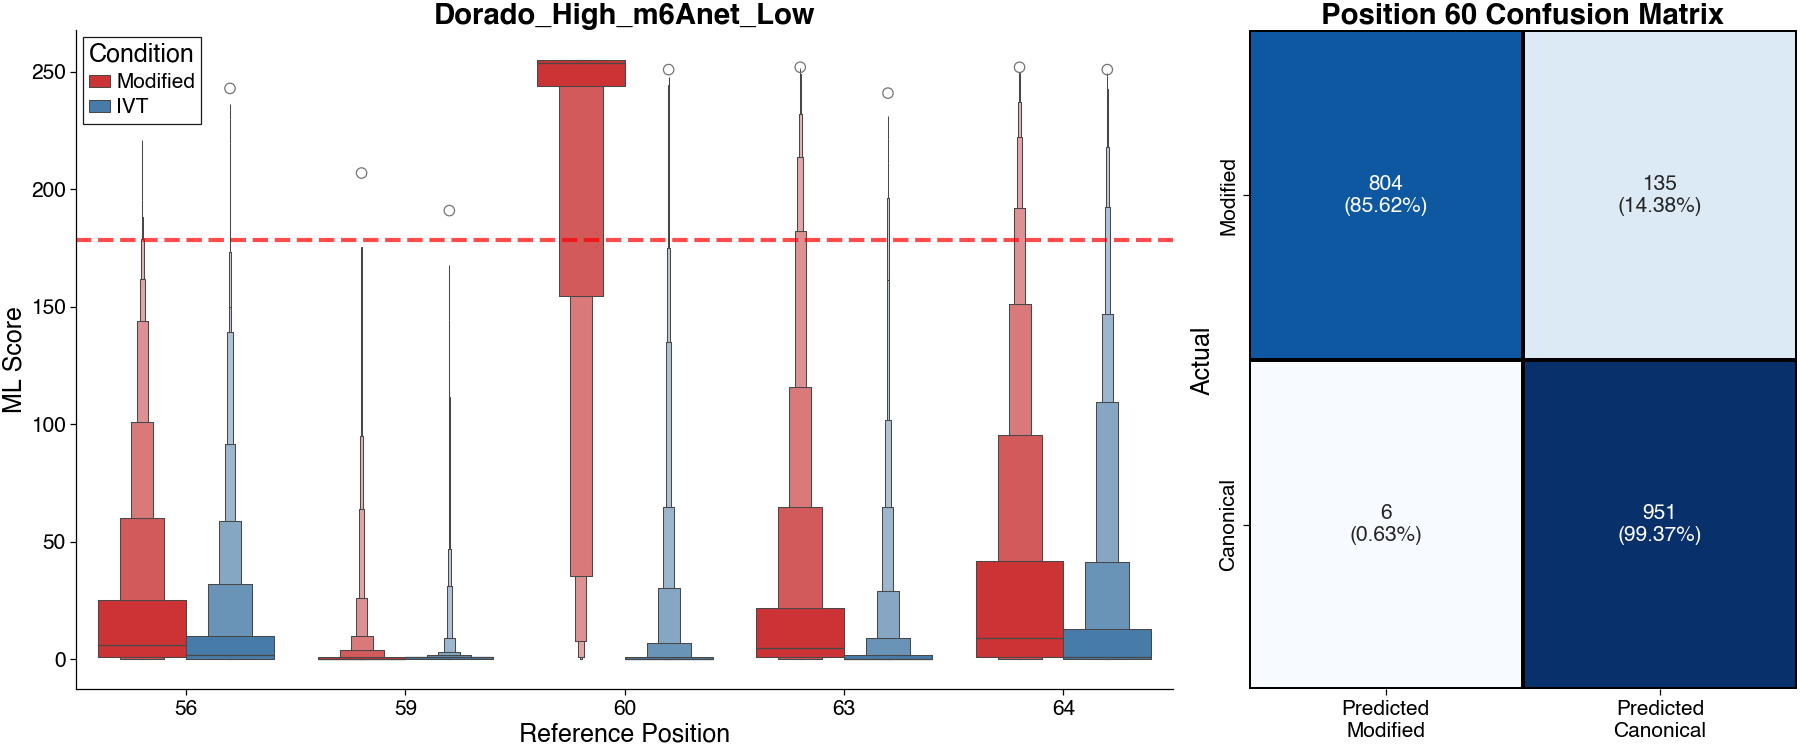

In [9]:
%matplotlib inline
def create_plot(plot_df, threshold=178.5, oligo_name="", position=60):
   """Create boxen plot with density-scaled confusion matrix."""
   
   fig, (ax_box, ax_cm) = plt.subplots(1, 2, figsize=(12, 5), 
                                        gridspec_kw={'width_ratios': [2, 1]})
   
   # BOXEN PLOT
   positions = sorted(plot_df['ref_pos'].unique())
   
   sns.boxenplot(
       x='ref_pos_str', y='ML_score', hue='condition', data=plot_df,
       palette='Set1',
       ax=ax_box, dodge=True, k_depth=10,
       order=[str(p) for p in positions]
   )
   
   ax_box.axhline(y=threshold, color='red', linestyle='--', linewidth=2, alpha=0.7)
   
   ax_box.set_title(f'{oligo_name}')
   ax_box.set_xlabel('Reference Position')
   ax_box.set_ylabel('ML Score')
   ax_box.legend(title='Condition', loc='upper left')
   
   # CONFUSION MATRIX
   metrics = calculate_confusion_metrics_position(plot_df, position, threshold)
   
   if metrics:
       cm_labels = np.array([
           [f"{metrics['tp']:,}\n({metrics['tp_pct']:.2f}%)", 
            f"{metrics['fn']:,}\n({metrics['fn_pct']:.2f}%)"],
           [f"{metrics['fp']:,}\n({metrics['fp_pct']:.2f}%)", 
            f"{metrics['tn']:,}\n({metrics['tn_pct']:.2f}%)"]
       ])
       
       cm_values = np.array([[metrics['tp'], metrics['fn']], 
                            [metrics['fp'], metrics['tn']]])
       
       sns.heatmap(cm_values, annot=cm_labels, fmt='', cmap='Blues',
                  xticklabels=['Predicted\nModified', 'Predicted\nCanonical'],
                  yticklabels=['Modified', 'Canonical'],
                  cbar=False, ax=ax_cm,
                  linewidths=1, linecolor='black')
       
       ax_cm.set_ylabel('Actual')
       ax_cm.set_xlabel('')
       ax_cm.set_title(f'Position {position} Confusion Matrix')
   
   return fig

# Create the plot
plot_df['ref_pos_str'] = plot_df['ref_pos'].astype(str)
fig = create_plot(plot_df, threshold=178.5, oligo_name=f"{OLIGO}", position=60)
plt.show()